In [1]:
#Author: Yiying Jiao


In [ ]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Load prepared dataset
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/21_250509_features_df.csv")

In [4]:
print(df)

           Close       pos      neut       neg  sentiment_score  \
0     126.239700  0.984030  0.001089  0.014881         0.969149   
1     127.800476  0.953821  0.045860  0.000318         0.953503   
2     123.498535  0.896802  0.025534  0.077664         0.819138   
3     127.712692  0.830714  0.095507  0.073780         0.756934   
4     128.815018  0.891560  0.047626  0.060814         0.830746   
...          ...       ...       ...       ...              ...   
1086  198.629532  0.834041  0.098161  0.067798         0.766243   
1087  198.250015  0.760118  0.162626  0.077255         0.682863   
1088  195.992981  0.760805  0.100788  0.138407         0.622398   
1089  197.231369  0.887714  0.041816  0.070470         0.817244   
1090  198.270004  0.897556  0.094154  0.008290         0.889266   

      rolling_sentiment  sentiment_volatility  price_change  volatility  \
0                   NaN                   NaN           NaN         NaN   
1                   NaN                   NaN

In [6]:

# Drop NaNs (from rolling/lag features)
df.dropna(inplace=True)


# Select features & target
features = ['Close','pos', 'neut', 'neg', 'sentiment_score','rolling_sentiment',
       'sentiment_volatility', 'price_change', 'volatility', 'momentum', 'rsi',
       'macd', 'ema', 'sentiment_lag_1', 'price_lag_1', 'sentiment_lag_2',
       'price_lag_2', 'sentiment_lag_3', 'price_lag_3', 'sentiment_lag_4',
       'price_lag_4', 'sentiment_lag_5', 'price_lag_5']
target = "next_close"  # we are predicting next day's price

X = df[features].values
y = df[target].values

# Normalize features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()  # Use StandardScaler
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))



In [7]:

timesteps = 1

# Split manually ensuring the time sequence remains intact
split_index = int(0.85 * len(df))  # 85% train, 15% test

# X
X_train_seq = X_scaled[:split_index]
X_test_seq = X_scaled[split_index:]

# y
y_train_seq = y_scaled[:split_index]
y_test_seq = y_scaled[split_index:]

# Reshape X for LSTM (samples, timesteps, features)
num_samples_test = X_test_seq.shape[0] // timesteps * timesteps
num_samples_train = X_train_seq.shape[0] // timesteps * timesteps
X_test_seq = X_test_seq[:num_samples_test]
X_test_seq = X_test_seq.reshape((num_samples_test // timesteps, timesteps, X_test_seq.shape[1]))
X_train_seq = X_train_seq[:num_samples_train]
X_train_seq = X_train_seq.reshape((num_samples_train // timesteps, timesteps, X_train_seq.shape[1]))


y_train_seq = y_train_seq[:num_samples_train]  # Trim y to match X
y_train_seq = y_train_seq.reshape(-1, timesteps)[:, -1]  # Keep only last value
y_train_seq = y_train_seq.reshape(-1, 1)  # Ensure correct shape

y_test_seq = y_test_seq[:num_samples_test]  # Trim y to match X
y_test_seq = y_test_seq.reshape(-1, timesteps)[:, -1]  # Keep only last value
y_test_seq = y_test_seq.reshape(-1, 1)  # Ensure correct shape

In [8]:
print("X_train_seq shape:", X_train_seq.shape)  # Should be (samples, timesteps, features)
print("y_train_seq shape:", y_train_seq.shape)  # Should be (samples, 1)
print("X_scaled shape:", X_scaled.shape)

X_train_seq shape: (861, 1, 23)
y_train_seq shape: (861, 1)
X_scaled shape: (1013, 23)


In [9]:
# Define LSTM Model

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),  # Last LSTM layer without return sequences
    Dropout(0.2),
    Dense(25, activation="tanh"), #switched from relu to tanh but not sure about which to use
    Dense(1, activation="linear")  # Output one value (next day return)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,301 (141.80 KB)

 Trainable params: 36,301 (141.80 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train model
history = model.fit(X_train_seq, y_train_seq, epochs=55, batch_size=16, validation_data=(X_test_seq, y_test_seq), verbose=1)


Epoch 1/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.5856 - mae: 0.6256 - val_loss: 1.8639 - val_mae: 1.3169
Epoch 2/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1349 - mae: 0.2755 - val_loss: 0.0873 - val_mae: 0.2572
Epoch 3/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0307 - mae: 0.1392 - val_loss: 0.0438 - val_mae: 0.1618
Epoch 4/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - mae: 0.1311 - val_loss: 0.0602 - val_mae: 0.2070
Epoch 5/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0292 - mae: 0.1306 - val_loss: 0.0589 - val_mae: 0.2065
Epoch 6/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216 - mae: 0.1159 - val_loss: 0.0507 - val_mae: 0.1863
Epoch 7/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0244 - mae: 0.1178 - val_loss: 0.0829 - val_mae: 0.2578
Epoch 8/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - mae: 0.1176 - val_loss: 0.0481 - val_mae: 0.1824
Epoch 9/55
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - mae:

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0626 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0293 - mae: 0.1299 
Scaled Train Loss mse, mae: [0.00728594558313489, 0.06633659452199936], Scaled Test Loss mse, Test mae: [0.0394957959651947, 0.14568057656288147]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Test MAE (£): 5.0288
Test RMSE (£): 6.8602
R² Score: 0.8250


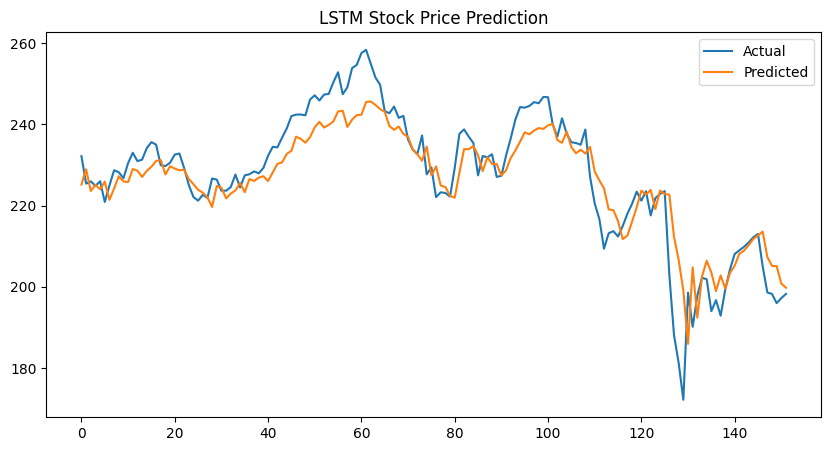

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Evaluate model
train_loss = model.evaluate(X_train_seq, y_train_seq)
test_loss = model.evaluate(X_test_seq, y_test_seq)
print(f"Scaled Train Loss mse, mae: {train_loss}, Scaled Test Loss mse, Test mae: {test_loss}")

# Make predictions
y_pred_scaled = model.predict(X_test_seq)

# Convert predictions back to original price scale
y_pred_original = scaler_y.inverse_transform(y_pred_scaled)

# Convert y_test back to original scale for comparison
y_test_original = scaler_y.inverse_transform(y_test_seq)

# Compute R²
mae_real = mean_absolute_error(y_test_original, y_pred_orignal)
rmse_real = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)
print(f"Test real MAE (£): {mae_real:.4f}, Test real RMSE (£): {rmse_real:.4f}")

print(f"R² Score: {r2:.4f}")


# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_orignal, label="Actual")
plt.plot(y_pred_orignal, label="Predicted")
plt.legend()
plt.title("LSTM Stock Price Prediction")
plt.show()
